In [3]:
%load_ext autoreload
%autoreload 3
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [4]:
import os
import pathlib

root = pathlib.Path(os.environ["DATA_ROOT"]).expanduser()

<IPython.core.display.Javascript object>

In [5]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
import plotnine as p9
import pandas as pd

import ocr

%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
!ls

demo_text_ocr.jpg   ocr.ipynb       requirements.in       Untitled.ipynb
eg.sh               ocr.py          requirements.txt      vis/
extract-frames.sh*  output_001.png  test-number.png
Makefile            __pycache__/    Untitled-Copy1.ipynb


<IPython.core.display.Javascript object>

In [26]:
def run_length_score(binary_image):
    pixel_counts = dict(zip(*np.unique(im1.ravel(), return_counts=True)))
    assert len(pixel_counts)<=2, "Should be a binary image."
    
    def row_run_lengths(row):
        return np.sum(row * (row >= np.roll(row, 1)))

    def column_run_lengths(col):
        return np.sum(col * (col >= np.roll(col, 1)))

    row_scores = np.apply_along_axis(row_run_lengths, 1, binary_image)
    col_scores = np.apply_along_axis(column_run_lengths, 0, binary_image)

    return np.sum(row_scores) + np.sum(col_scores)

def rotate_image(image, angle, border_value=0):
    rows, cols = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows), borderValue=border_value)
    return rotated_image

def straighten_image_maximize_run_length(binary_image, angle_range=(-10, 10), num_angles=100):
    best_score = -1
    best_angle = 0

    angles = np.linspace(angle_range[0], angle_range[1], num_angles)

    for angle in angles:
        rotated_image = rotate_image(binary_image, angle)
        score = run_length_score(rotated_image)
        
        if score > best_score:
            best_score = score
            best_angle = angle

    # Apply the best rotation angle to the image
    straightened_image = rotate_image(binary_image, best_angle)

    return straightened_image


<IPython.core.display.Javascript object>

[[[128  84]]

 [[127  85]]

 [[124  85]]

 [[123  86]]

 [[121  86]]

 [[120  87]]

 [[119  87]]

 [[118  88]]

 [[117  88]]

 [[117  89]]

 [[121  93]]

 [[153  93]]

 [[154  94]]

 [[157  94]]

 [[158  93]]

 [[158  90]]

 [[156  88]]

 [[156  86]]

 [[155  85]]

 [[129  85]]]
[[[ 97  83]]

 [[ 96  84]]

 [[ 95  84]]

 [[ 95  89]]

 [[ 94  90]]

 [[ 94  91]]

 [[ 95  92]]

 [[103  92]]

 [[104  91]]

 [[104  84]]

 [[ 98  84]]]
[[[43 81]]

 [[42 82]]

 [[39 82]]

 [[38 83]]

 [[37 83]]

 [[36 84]]

 [[33 84]]

 [[31 86]]

 [[34 89]]

 [[35 89]]

 [[36 90]]

 [[52 90]]

 [[53 91]]

 [[72 91]]

 [[72 88]]

 [[70 86]]

 [[70 83]]

 [[69 82]]

 [[46 82]]

 [[45 81]]]
[[[165  54]]

 [[164  55]]

 [[163  55]]

 [[159  59]]

 [[159  61]]

 [[158  62]]

 [[158  86]]

 [[160  88]]

 [[160  91]]

 [[161  92]]

 [[161  93]]

 [[164  93]]

 [[166  91]]

 [[166  90]]

 [[167  89]]

 [[167  77]]

 [[168  76]]

 [[168  75]]

 [[167  74]]

 [[167  54]]]
[[[119  51]]

 [[119  52]]

 [[117  54]]

 [[1

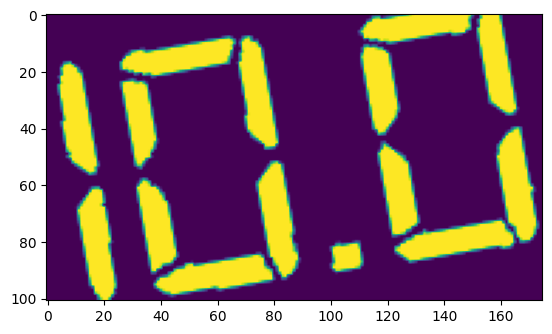

<IPython.core.display.Javascript object>

In [47]:
import cv2
import numpy as np
from skimage.transform import hough_line, hough_line_peaks


def correct_rotation(image):
    edges = cv2.Canny(image, 50, 150)
    hspace, angles, distances = hough_line(edges)

    _, _, angles = hough_line_peaks(hspace, angles, distances)
    mean_angle = np.mean(angles)

    rotation_angle = np.rad2deg(mean_angle) % 180
    if rotation_angle > 90:
        rotation_angle -= 180

    print(f"{rotation_angle=}")

    rows, cols = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
    rotated_image = cv2.warpAffine(
        image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE
    )

    return rotated_image


def rotate_image(image, angle):
    rows, cols = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(
        image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE
    )
    return rotated_image


def correct_rotation(image, angle_range=(-10, 10), num_angles=100):
    best_score = float("inf")
    best_angle = 0

    angles = np.linspace(angle_range[0], angle_range[1], num_angles)

    for angle in angles:
        rotated_image = rotate_image(image, angle)
        moments = cv2.moments(rotated_image)
        score = moments["mu02"] + moments["mu20"]

        if score < best_score:
            best_score = score
            best_angle = angle

    print(f"{best_angle=}")

    corrected_image = rotate_image(image, best_angle)
    return corrected_image


def correct_rotation(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    angles = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        if w > 0 and h > 0:
            aspect_ratio = float(w) / h
            if 0.2 < aspect_ratio < 0.8:
                _, (w, h), angle = cv2.minAreaRect(contour)
                if w < h:
                    angle += 90
                angles.append(angle)

    if not angles:
        return image

    median_angle = np.median(angles)
    corrected_image = rotate_image(image, median_angle)
    return corrected_image


def correct_rotation(image, angle_range=(-10, 10)):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    angles = []
    for contour in contours:
        print(contour)
        _, _, w, h = cv2.boundingRect(contour)
        if w > 0 and h > 0:
            aspect_ratio = float(w) / h
            if 0.2 < aspect_ratio < 0.8:
                _, (w, h), angle = cv2.minAreaRect(contour)
                if w < h:
                    angle += 90
                angles.append(angle)

    if not angles:
        return image

    median_angle = np.median(angles)

    # Limit the rotation angle to the specified range
    median_angle = max(angle_range[0], min(median_angle, angle_range[1]))

    corrected_image = rotate_image(image, median_angle)
    return corrected_image


def preprocess_seven_segment_image(image_path):
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(
        grayscale_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    rotated_image = correct_rotation(binary_image)
    # rotated_image = binary_image

    # kernel = np.ones((2, 2), np.uint8)
    # cleaned_image = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, kernel)
    cleaned_image = rotated_image

    return cleaned_image


# Example usage:
image_path = "test-number.png"
preprocessed_image = preprocess_seven_segment_image(image_path)
plt.imshow(preprocessed_image)

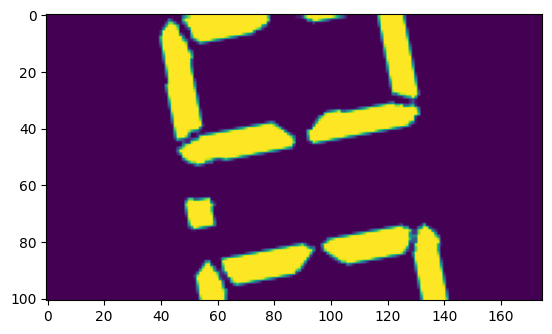

<IPython.core.display.Javascript object>

In [20]:
im1, im2 = ocr.process_image("test-number.png")

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


<IPython.core.display.Javascript object>

In [28]:
np.unique(rotate_image(im1, 1).ravel())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  22,  23,  24,  25,  26,  27,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,
        58,  60,  62,  63,  64,  65,  67,  68,  71,  72,  73,  74,  75,
        77,  78,  80,  81,  82,  84,  85,  87,  88,  93,  94,  95,  96,
        97, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 115,
       118, 119, 120, 121, 123, 124, 126, 128, 129, 130, 131, 132, 134,
       135, 136, 137, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151,
       152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 164, 165, 167,
       168, 170, 171, 173, 175, 176, 177, 178, 180, 181, 183, 184, 185,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 212, 213, 215, 217, 218,
       219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 23

<IPython.core.display.Javascript object>

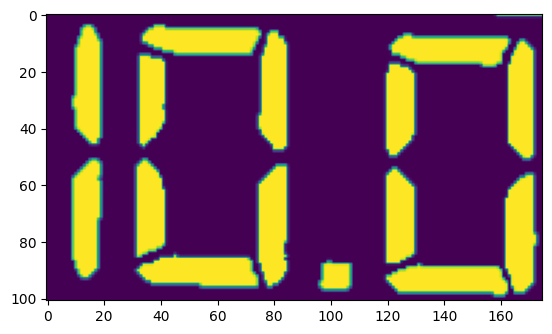

<IPython.core.display.Javascript object>

In [17]:
plt.imshow(im2)

In [62]:
def load_image(image_path):
    # Load the image
    # image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    return np.fliplr(np.flipud(image))


def deskew_image(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply a binary threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Get the coordinates of the non-zero pixels
    coords = np.column_stack(np.where(thresh > 0))

    # Compute the minimum rotated bounding box
    angle = cv2.minAreaRect(coords)[-1]
    print(f"{angle=}")

    # Correct the angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get the image size
    (h, w) = gray.shape[:2]

    # Calculate the center of the image
    center = (w // 2, h // 2)

    # Rotate the image using the computed angle
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(
        gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    return rotated


def preprocess_image(image):
    # Resize the image
    scale_percent = 150
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

    # Apply binary thresholding
    _, thresholded = cv2.threshold(
        resized, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )

    # Apply morphological operations
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Remove noise
    denoised = cv2.fastNlMeansDenoising(
        closing, h=20, templateWindowSize=7, searchWindowSize=21
    )

    return denoised


def segment_image(image, k=3):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # Convert to floating-point
    pixels = np.float32(pixels)

    # Define the criteria and apply k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    _, labels, centers = cv2.kmeans(
        pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )

    # Convert back to 8-bit values
    centers = np.uint8(centers)

    # Map the segmented image
    segmented_image = centers[labels.flatten()]

    # Reshape the image to its original dimensions
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

<IPython.core.display.Javascript object>

In [52]:
# p9.ggplot(pd.DataFrame(dict(x=np.ravel(img))), p9.aes(x="x")) + p9.geom_histogram()

<IPython.core.display.Javascript object>

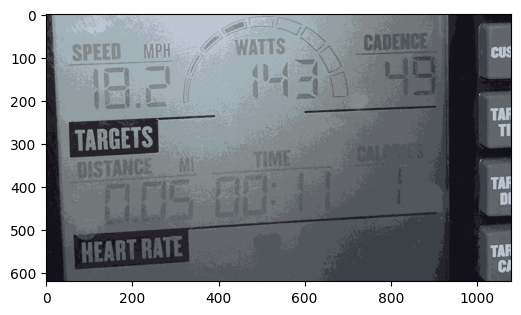

<IPython.core.display.Javascript object>

In [64]:
plt.rcParams["figure.figsize"] = (6, 12)
img = load_image(root / "0117.png")
img = img[900:-400, :, :]
plt.imshow(img)

plt.imshow(segment_image(img, k=10))
# plt.imshow(img)

# plt.imshow(deskew_image(img))

# plt.imshow(np.where(img < 100, img, 255))


# (img, dpi=600)

In [ ]:
from pytesseract import pytesseract

# Set the path to the Tesseract executable
pytesseract.tesseract_cmd = r'/path/to/tesseract'

# Preprocess the image
image_path = 'path/to/your/image.jpg'
preprocessed_image = preprocess_image(image_path)

# Run Tesseract OCR on the preprocessed image
text = pytesseract.image_to_string(preprocessed_image)
print(text)
